## makemore: Wavenet

In [4]:
# there no change change in the first several cells from last lecture

In [5]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [6]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [7]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [8]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [12]:
class EmbeddingLayer:
    def __init__(self, input_dim, emb_dim):
        self.C = torch.randn((input_dim, emb_dim))

    def __call__(self, input):
        self.out = self.C[input]
        return self.out
    
    def parameters(self):
        return [self.C]
    
class FlattenLayer:
    def __init__(self, n_elements):
        self.n = n_elements

    def __call__(self, input):
        dims = len(input.shape)
        if dims == 2:
            self.out = input.view(input.shape[0], -1)
        elif dims == 3:
            self.out = input.view(input.shape[0], input.shape[1]//self.n, -1).squeeze(1)
        else:
            raise Exception(f'A tensor of {dims} dimensions is not accepted by the FlattenLayer')
        return self.out
    
    def parameters(self):
        return []
    
class LinearLayer:
    def __init__(self, input_dim, neurons, bias=True):
        self.W = torch.randn((input_dim, neurons)) / input_dim**0.5
        self.b = torch.zeros((1, neurons)) if bias else None
    
    def __call__(self, inputs):
        self.out = inputs @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out
    
    def parameters(self):
        return [self.W] + ([] if self.b is None else [self.b])
    
class BatchNormLayer:
    def __init__(self, input_dims, momentum=0.1, epsilon=1e-5):
        self.momentum = momentum
        self.epsilon = epsilon
        self.training = True
        self.running_mean = torch.zeros((1, input_dims))
        self.running_var = torch.ones((1, input_dims))
        self.bngain = torch.ones((1, input_dims))
        self.bnbias = torch.zeros((1, input_dims))

    def __call__(self, inputs):
        if self.training:
            dims = len(inputs.shape)
            if dims == 2:
                bmean = inputs.mean(0, keepdim=True)
                bvar = inputs.var(0, keepdim=True, unbiased=True)
            elif dims == 3:
                bmean = inputs.mean((0,1), keepdim=True)
                bvar = inputs.var((0,1), keepdim=True, unbiased=True)
            else:
                raise Exception(f'Inputs of {dims} dimensions are not supported for the BatchNormLayer')
        else:
            bmean = self.running_mean
            bvar = self.running_var

        # Updating statistics
        if self.training:
            with torch.no_grad():
                self.running_mean = self.running_mean * (1-self.momentum) + bmean * self.momentum
                self.running_var = self.running_var * (1-self.momentum) + bvar * self.momentum

        self.out = self.bngain * ((inputs - bmean) / torch.sqrt(bvar + self.epsilon)) + self.bnbias
        return self.out
    
    def parameters(self):
        return [self.bngain, self.bnbias]
    

class Activation:
    def __init__(self, act_fn_name):
        if act_fn_name == 'tanh':
            self.act_fn = torch.tanh
        else:
            raise Exception('Pass a valid activation function name')
    
    def __call__(self, inputs):
        self.out = self.act_fn(inputs)
        return self.out
    
    def parameters(self):
        return []
    

class Sequential:
    def __init__(self, layers):
        self.layers = layers
        for layer in self.layers:
            layer.training = True
    
    def __call__(self, inputs):
        x = inputs
        for layer in self.layers:
            x = layer(x)
            # print(layer.__class__.__name__, x.shape)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    
    def eval(self):
        for layer in self.layers:
            layer.training = False
    
    def train(self):
        for layer in self.layers:
            layer.training = True


In [13]:
torch.manual_seed(42); # seed rng for reproducibility

In [17]:
# Exercise 4: putting it all together!
# Train the MLP neural net with your own backward pass

# init
n_embd = 24 # the dimensionality of the character embedding vectors
n_hidden = 128 # the number of neurons in the hidden layer of the MLP

model = Sequential([EmbeddingLayer(vocab_size, n_embd),
                    FlattenLayer(2), LinearLayer(n_embd * 2, n_hidden, bias=False), BatchNormLayer(n_hidden, 0.01), Activation('tanh'),
                    FlattenLayer(2), LinearLayer(n_hidden*2, n_hidden, bias=False), BatchNormLayer(n_hidden, 0.01), Activation('tanh'),
                    FlattenLayer(2), LinearLayer(n_hidden*2, n_hidden, bias=False), BatchNormLayer(n_hidden, 0.01), Activation('tanh'),
                    LinearLayer(n_hidden, vocab_size)
                    ])

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

# same optimization as last time
max_steps = 200000
batch_size = 32
n = batch_size # convenience
lossi = []

# kick off optimization
for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  # -----------------

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

  # if i >= 100: # TODO: delete early breaking when you're ready to train the full net
  #   break

76579
      0/ 200000: 3.3634
  10000/ 200000: 2.2010
  20000/ 200000: 1.7158
  30000/ 200000: 1.7934
  40000/ 200000: 2.3977
  50000/ 200000: 1.8984
  60000/ 200000: 1.9226
  70000/ 200000: 2.0509
  80000/ 200000: 1.4395
  90000/ 200000: 2.1200
 100000/ 200000: 1.8602
 110000/ 200000: 1.7601
 120000/ 200000: 2.0392
 130000/ 200000: 2.6380
 140000/ 200000: 1.8521
 150000/ 200000: 1.9176
 160000/ 200000: 2.1405
 170000/ 200000: 1.9778
 180000/ 200000: 1.7679
 190000/ 200000: 1.8104


In [18]:
print('input', Xb.shape)
for layer in model.layers:
    print(layer.__class__.__name__, layer.out.shape)

input torch.Size([32, 8])
EmbeddingLayer torch.Size([32, 8, 24])
FlattenLayer torch.Size([32, 4, 48])
LinearLayer torch.Size([32, 4, 128])
BatchNormLayer torch.Size([32, 4, 128])
Activation torch.Size([32, 4, 128])
FlattenLayer torch.Size([32, 2, 256])
LinearLayer torch.Size([32, 2, 128])
BatchNormLayer torch.Size([32, 2, 128])
Activation torch.Size([32, 2, 128])
FlattenLayer torch.Size([32, 256])
LinearLayer torch.Size([32, 128])
BatchNormLayer torch.Size([32, 128])
Activation torch.Size([32, 128])
LinearLayer torch.Size([32, 27])


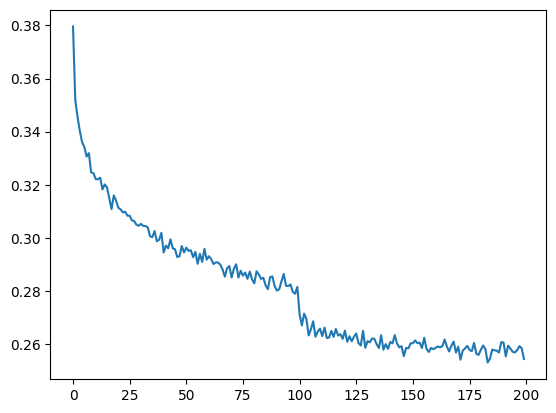

In [19]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [20]:
# evaluate train and val loss
model.eval()

@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7854483127593994
val 1.9937665462493896


In [22]:
# sample from the model
model.eval()

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass
      logits = model([[context]])
      # sample
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break

    print(''.join(itos[i] for i in out))

charryn.
leilany.
trego.
ashjoun.
braylene.
nuheela.
eppeana.
treyvon.
zaisha.
sanaya.
tamsi.
ryde.
camree.
nazelle.
marval.
takiyah.
zerah.
drue.
ayesha.
ahring.
